In [1]:
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, root
import axion_motion
import model
import transport_equation
import reheating
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion
from axion_leptogenesis import model as original_model

# Plot of the Evolution of the System

In [54]:
def sim_and_plot(m_a, Gamma_phi, H_inf, f_a, filename=None, t_end=5e-5, T_end=4e11):
    decay_rate = calc_Gamma_a_SU2(m_a, f_a)
    m1 = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
    m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))
    #s1 = model.solve(m1, (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
    #s2 = rad_dom_model.solve(m2, cosmology.calc_reheating_temperature(Gamma_phi), (1,0), 
    #                         f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
    #print(s1, s2)
    r1 = model.solve_to_end(m1, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=t_end)
    T_RH = cosmology.calc_reheating_temperature(Gamma_phi)
    r2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=T_end, collect=True)
    plot(r1, r2, filename, m_a=m_a, Gamma_phi=Gamma_phi, H_inf=H_inf)
    return ((m1, m2), (r1, r2))

In [55]:
H_inf = 2e10
f_a = 2e14

<ipython-input-53-231762b49638>:25: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-53-231762b49638>:25: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


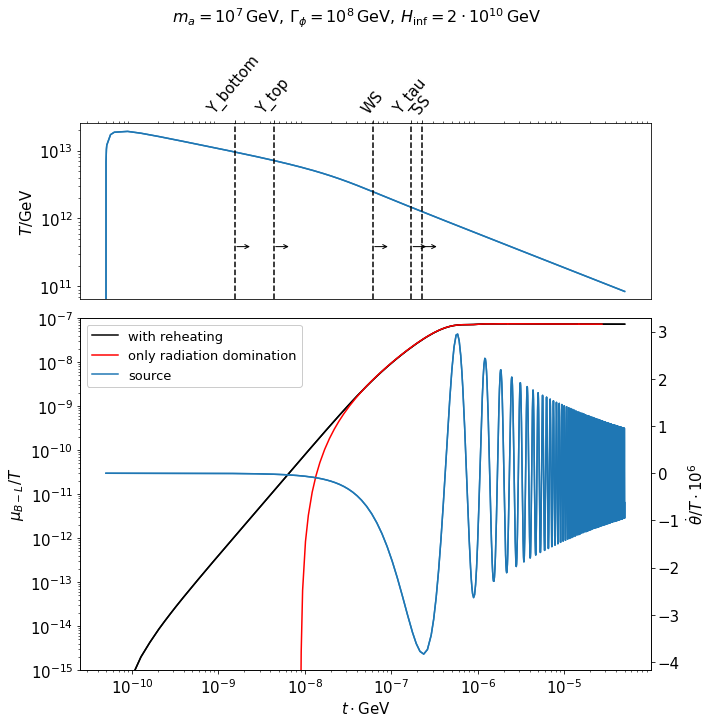

In [56]:
sim_and_plot(1e7, 1e8, H_inf, f_a, filename="evolution.pdf");

<ipython-input-7-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-7-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


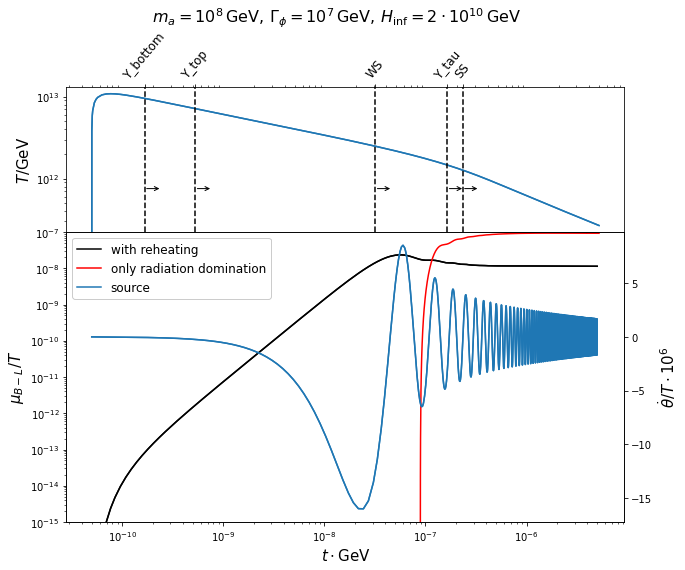

CPU times: user 8.63 s, sys: 40 ms, total: 8.67 s
Wall time: 8.45 s


In [15]:
%time (m1, m2), (r1, r2) = sim_and_plot(1e8, 1e7, H_inf, f_a, t_end=5e-6, T_end=3e11)

In [17]:
import axion_decay

In [18]:
axion_decay.compute_axion_decay

<function axion_decay.compute_axion_decay(T_start, red_chem_B_minus_L, theta, theta_dot, m_a, f_a, axion_decay_rate)>

In [80]:
# with reheating
m_a = m1.axion_parameter[0]
f_a_range = np.geomspace(1e11, 1e17, 40)
decay_rate = calc_Gamma_a_SU2(m_a, f_a)
r = r1[-1]
rh = [axion_decay.compute_axion_decay(r.T_fn(r.t[-1]), r.red_chem_B_minus_L[-1], *r.axion_fn(np.log(r.t[-1])), m_a, f_a, decay_rate) for f_a in f_a_range]

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:8: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


In [81]:
# radiation domaination 
r = r2[-1]
rad = [axion_decay.compute_axion_decay(r.T[-1], r.red_chem_B_minus_L[-1], *r.axion.T[-1], m_a, f_a, decay_rate) for f_a in f_a_range]

In [87]:
f_a = 1e16

r = r1[-1]
T_rh = r.T_fn(r.t[-1])
rho_a_rh = np.sum(0.5 * f_a**2 * r.axion_fn(np.log(r.t[-1]))**2 * [m_a**2, 1])

r = r2[-1]
T_rad = r.T[-1]
rho_a_rad = np.sum(0.5 * f_a**2 * r.axion.T[-1]**2 * [m_a**2, 1]) # for the last f_A

In [107]:
def solve_decay(T, rho_a):
    domain = np.log((cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))),
                        30 / decay_rate))
    R0 = 1
    intitial = np.log((cosmology.calc_radiation_energy_density(T), rho_a, R0))
    sol = solve_ivp(axion_decay.rhs_axion_decay, domain, intitial, args=(decay_rate,))
    return sol
    #rho_R, rho_a, R = np.exp(sol.y)
    #current = (R0 / R)**3 * 
    #T = cosmology.calc_temperature(rho_R)
    #n_gamma = cosmology.calc_photon_number_density(T)

In [108]:
s_rad = solve_decay(T_rad, rho_a_rad)
s_rh = solve_decay(T_rh, rho_a_rh)

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:8: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


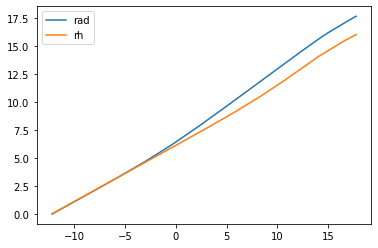

In [111]:
plt.plot(s_rad.t, s_rad.y[2], label="rad")
plt.plot(s_rh.t, s_rh.y[2], label="rh")
plt.legend()

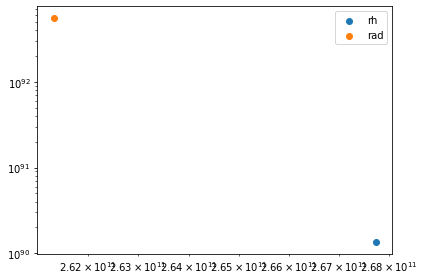

In [86]:
plt.scatter([T_rh], [rho_a_rh], label="rh")
plt.scatter([T_rad], [rho_a_rad], label="rad")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.tight_layout()

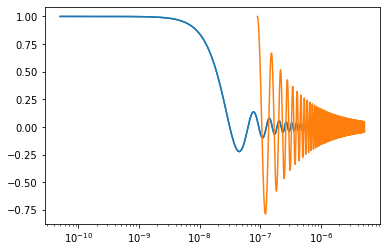

In [119]:
for r in r1:
    plt.semilogx(r.t, r.axion_fn(np.log(r.t))[0], color="tab:blue")
for r in r2:
    t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(r.T)))
    plt.semilogx(t, r.axion[0], color="tab:orange")

Text(0, 0.5, 'eta_B after axion decay')

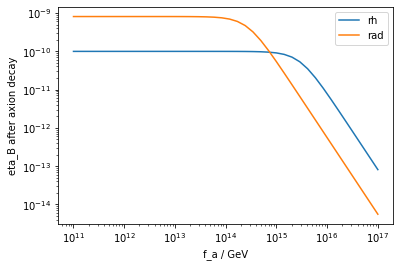

In [59]:
plt.loglog(f_a_range, rh, label="rh")
plt.loglog(f_a_range, rad, label="rad")
plt.legend()
plt.xlabel("f_a / GeV")
plt.ylabel("eta_B after axion decay")

# Plot of the Parameter Space

In [36]:
m_a_range = np.geomspace(1e6, 1e9, 11)
Gamma_phi_range = np.geomspace(1e6, 1e9, 10)

In [37]:
%%time
eta_B_rh = [[model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), 
                                                      (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

CPU times: user 5min 53s, sys: 49.4 ms, total: 5min 53s
Wall time: 5min 53s


In [41]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), 
                                                                           (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

../transport_eq/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


CPU times: user 3min 49s, sys: 15.9 ms, total: 3min 49s
Wall time: 3min 49s


In [39]:
%%time
eta_B_original = [[original_model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

CPU times: user 14.6 s, sys: 3.99 ms, total: 14.7 s
Wall time: 14.7 s


In [4]:
fname = "background_cosmology_comparison.pkl"
#util.save_data(fname, m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh)
m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh = util.load_data(fname)

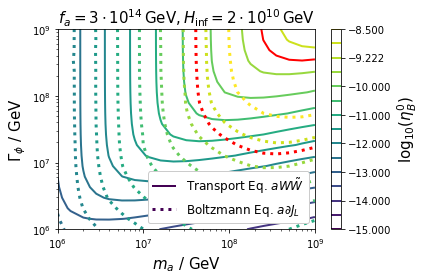

In [24]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          0.5), np.log10(constants.eta_B_observed)])
levels.sort()

#levels = np.hstack([np.linspace(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
#          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
#          10), np.log10(constants.eta_B_observed)])
#levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels, linewidths=2)
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

#CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, 
#                  linestyles="--")
#CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS3 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_original), levels, linestyles=":", linewidths=3)
CS3.collections[np.where(CS3.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(r"$f_a = %s \, \mathrm{GeV}, H_\mathrm{inf} = %s \, \mathrm{GeV}$" % (latex_exponential_notation(f_a), latex_exponential_notation(H_inf)), fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
#h2, _ = CS2.legend_elements()
h3, _ = CS3.legend_elements()
#plt.legend([h1[0], h2[0], h3[0]], ["pure rad. dom.", "reheating", "original"], framealpha=1.0, loc=4)
plt.legend([h1[0], h3[0]], [r"Transport Eq. $a W \tilde{W}$", "Boltzmann Eq. $a \partial J_L$"], 
           framealpha=1.0, loc=4, fontsize=12)

plt.tight_layout()
plt.savefig(util.make_plot_path("transport_vs_boltzmann.pdf"))